# Daymet V4 - Deriving Climatological Normals and Anomalies from Analysis Ready Subsets

*Author:  ORNL DAAC*
<br>
*Date: August 31, 2021*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/):  uso@daac.ornl.gov*

##### Keywords:  ORNL DAAC, Daymet, THREDDS, OPeNDAP, Earthdata, Python Geospatial Tools, Xarray

# Tutorial Overview

**In this tutorial, we will programmatically discover, access, and subset Daymet V4 Datasets based on an area-of-interest (CONUS) and defined time period.  We'll access Daymet V4 Annual and Monthly Climatologies that are distributed from the ORNL DAAC as well as Daymet V4 2021 Daily data files that are now distributed as a lower latency product.  Once these subset files are created, they are "analysis ready" and we will demonstrate using Python's Xarray functionality aggregating those data to climate normals and anomalies.**

![title](images/JuneAnomaly_saveas.png)

## Source Data
* [Daymet V4 Monthly Climatologies](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1855)  `https://doi.org/10.3334/ORNLDAAC/1855`

<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S. Kao, and B.E. Wilson. 2020. Daymet: Monthly Climate Summaries on a 1-km Grid for North America, Version 4. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1855
</div>

* [Daymet V4 Daily Data - Monthly Latency](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1904)  `https://doi.org/10.3334/ORNLDAAC/1904 `

<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, P.E. Thornton, S. Kao, Y. Wei, and B.E. Wilson. 2021. Daymet Version 4 Monthly Latency: Daily Surface Weather Data. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1904 </div>

* [Daymet V4 Annual Climatologies](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1852)  `https://doi.org/10.3334/ORNLDAAC/1852`  

<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S. Kao, and B.E. Wilson. 2020. Daymet: Annual Climate Summaries on a 1-km Grid for North America, Version 4. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1852
</div>

***
***

### The generalized steps we'll take in this tutorial
1. Establish `search parameters` based on a polygon boundary file and other criteria for searching and subsetting Daymet Data
1. Using defined search parameters, programmatically search NASA's Earthdata Collections to discover files/granules that fall within our search parameters
1. Utilizing OPeNDAP and Xarray, subset, and download files of interest
1. From Analysis Ready subsets, generate climatology data files for the time periods of interest 


### These Exercises were produced using the following Python Versions, Modules, and Libraries
* Python 3.7 or higher
* geopandas and dependencies
* pydap
* xarray
* rasterio
* shapely

----

# Setting Search and Subset Parameters
## Step 1.  Spatial Area of Interest and Time Range of Interest

We'll start by establishing search and subsetting parameters.

We'll use Python's [GeoPandas](https://geopandas.org/index.html) to provide a spatial extent from a the polygon file.

* **`Geopandas`** is a Python library that enables the use and manipulation of geospatial data. It extends the common datatype used in pandas to allow for many and unique geometric operations.

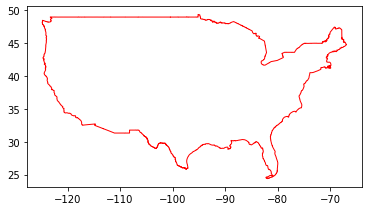

In [1]:
import geopandas as gpd
conus_poly = gpd.read_file('bnds/conus_singlepart.shp')
ax = conus_poly.plot(color = 'none', edgecolor = 'red')

In [2]:
conus_poly.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

#### Data can be re-projected using the **`GeoDataFrame.to_crs`** command:
We'll establish bounding box coordinates in 2 reference systems to be used in the following:
1. **Geographic** - for searching NASA Earthdata metadata

In [3]:
conus_poly_4326 = conus_poly.to_crs(epsg=4326) #project to WGS84
xy_4326 = conus_poly_4326.bounds # bound of the conus polygon in lat, lon
#print(xy_4326)
#print(' ')
xy_list = xy_4326.values.tolist()[0]
print(xy_list)

[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]


2. **Lambert Conformal Conic** - Daymet's crs - for subsetting the file using OPeNDAP protocols

In [4]:
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
conus_poly_lcc = conus_poly.to_crs(daymet_proj) # to_crs re-projects from UTM 17N to LCC
conus_poly_lcc.crs
# We'll use the boounding box of the polygon file in Lambert Conformal Conic projection to subset the actual data 
# using OPeNDAP protocols.  
lccbounds = conus_poly_lcc.bounds # Bounds in LCC projection
print('Projected bounding box of the CONUS polygon file in LCC projection')
lccbounds.round(2)

Projected bounding box of the CONUS polygon file in LCC projection


,minx,miny,maxx,maxy
0,-1956186.38,-1785922.02,2433990.38,946300.54


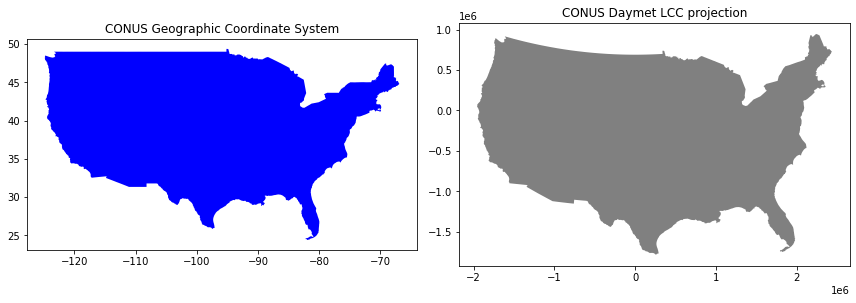

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
conus_poly.plot(ax=ax1, facecolor='blue');
ax1.set_title("CONUS Geographic Coordinate System");
conus_poly_lcc.plot(ax=ax2, facecolor='grey');
ax2.set_title("CONUS Daymet LCC projection");
plt.tight_layout()

#### We'll set the `time period` of interest and Daymet `variable` from which to subset data.

For this exercise, we'll search for and access **30 years of data, from 1991 to 2020**

In [6]:
import datetime as dt 
# We'll download 30 years of data starting in 1991 and ending in 2020.
start_date = dt.datetime(1991, 1, 1) # specify your own start date
end_date = dt.datetime(2020, 12, 31)  # specify your end start date

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
print(temporal_str)

var = 'tmax' # select your own variable
var

1991-01-01T00:00:00Z,2020-12-31T00:00:00Z


'tmax'

# EXERCISE 1:  Daymet V4 Monthly Normal and Anomaly
## Step 1.  Monthly (June) Normal for CONUS from Daymet V4 Monthly Climatologies

**In this exercise, we'll create a `Monthly Normal`.  Then we'll calculate the `Anomaly` for this past June, 2021**

## Step 1.1. Examine one Monthly File to See Internal Structure

**We'll access a monthly file directly from the ORNL DAAC's OPeNDAP Server**
`daymet_v4_tmax_monavg_na_1991.nc`

[Daymet V4 Monthly Climatologies](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1855/catalog.html) through the THREDDS Catalog

In [7]:
# Let's use Pydap and Xarray to look into *ONE* of the monthly netCDF files to examine the structure of the netCDF file
from pydap.client import open_url 
import xarray as xr

m1_granule_dap = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/daymet_v4_tmax_monavg_na_1991.nc'

m1_thredds_ds = open_url(m1_granule_dap)
ds_tmax_monavg_na_1991 = xr.open_dataset(xr.backends.PydapDataStore(m1_thredds_ds), decode_coords="all")

#ds_tmax_monavg_na_1991.info()  #netCDF file representation 

ds_tmax_monavg_na_1991  ## Xarray's html representation


<xarray.Dataset>
Dimensions:                  (nv: 2, time: 12, x: 7814, y: 8075)
Coordinates:
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 1991-01-16T12:00:00 ... 19...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    tmax                     (time, y, x) float32 ...
Attributes:
    start_year:                      1991
    source:                          Daymet Software Version 4.0
    Version_software:                Daymet Software Version 4.0
    Version_data:                    Daymet Data Version 4.0
    Conventions:                     CF-1.6
    citation:                        Please see http://daymet.ornl.gov/ for c...
    references:                      Please see http://daymet.ornl.gov/ for c...
    NCO:                             netCDF Operators version 4.9.3 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

## Step 1.2.  Monthly Climatologies - NASA Earthdata Search

### Collection' s Concept_ID

- Using Python's **`requests`** library, we will build and provide an HTTP request to search and discover **`NASA's Earthdata Collections`** for Daymet V4 Monthly Climate Collection **Concept_id**

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/collections
</div>

### Daymet Granules (Files)

- We'll do a granule-level search of NASA's Earthdata Holdings for all the data `granules` that are within are established search criteria.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>

In [8]:
#Concept_ID
import requests
m_daymet_doi = '10.3334/ORNLDAAC/1855' # Monthly CLIMATES DOI
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
m_doisearch = cmrurl + 'collections.json?doi=' + m_daymet_doi # 
print('Earthdata Metadata DaymetV4 Monthly Climates --> ' , m_doisearch)

m_response = requests.get(m_doisearch)
m_collection = m_response.json()['feed']['entry'][0]
#print(collection)
m_concept_id = m_collection['id']
print('NASA Earthdata Collection Concept_ID - Monthly Climates --> ' , m_concept_id)

print(' ')

print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variable :', var)
print('geographic bounding box    :')
print(xy_list)
print('concept ID      :', m_concept_id)
print('cmr url         :', cmrurl)

Earthdata Metadata DaymetV4 Monthly Climates -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1855
NASA Earthdata Collection Concept_ID - Monthly Climates -->  C2024906320-ORNL_CLOUD
 
Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 1991-01-01T00:00:00Z,2020-12-31T00:00:00Z
Daymet variable : tmax
geographic bounding box    :
[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]
concept ID      : C2024906320-ORNL_CLOUD
cmr url         : https://cmr.earthdata.nasa.gov/search/


### Build Granules Request URL and Obtain Granule List

In [9]:
#Granule List
m_granulesearch = cmrurl + 'granules.json?collection_concept_id=' + m_concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_list))
print(m_granulesearch)

response = requests.get(m_granulesearch)
m_granules = response.json()['feed']['entry']  
m_granule_names = []

for g in m_granules:
    m_granule_name = g['title']
    if var in m_granule_name:
        m_granule_names.append(m_granule_name)
        print(m_granule_name)

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2024906320-ORNL_CLOUD&page_size=1000&temporal=1991-01-01T00:00:00Z,2020-12-31T00:00:00Z&bounding_box[]=-124.84897400000001,24.39630800000002,-66.88507499999997,49.38435799999999
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1991.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1991.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1992.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1992.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1993.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1993.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1994.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1994.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1995.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1995.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1996.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_mon

## Step 1.3. Subset Monthly Maximum Temperature Climatologies to CONUS and June

###  We'll use Pythons **`pydap`** library

* **`pydap`** can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally.  Data can be downloaded on-the-fly as needed.

###  We'll use Python's **`Xarray`** Library to 
* open the data files for which we are searching
* subset the North American file based on the Lambert Conformal Conic **`lccbounds`** bounding box we defined earlier
* concatenate the time range into one file
* save the concatened file to a netCDF file

Pydap
* **`open_url`**

Xarray
* **`open_dataset`** 
* **`sel`**
* **`slice`**
* **`concat`**
* **`to_netcdf`**

**We'll narrow the granules to netCDF files and add a *`TIME SLICE`* to extract only the June Files**

* ##### Programmatically select for `netCDF` files
* ##### Subset to CONUS and concatenate Monthly `June` files into one netCDF file
* ##### Save file as tmax_concatJuneMonAvg_conussubset.nc - 30 years of June - 1991-2020

In [10]:
##### DO NOT RUN DURING WEBINAR #####
# Programmatically select for netCDF files
# Subset and concatenate June files into one netCDF file
# Save file as tmax_concatJuneMonAvg_conussubset.nc - 30 years of June - 1991-2020
from pydap.client import open_url
#from pydap.cas.urs import setup_session # setup_session 
import xarray as xr
import time

#ds_tmax_monavg_na_1991 = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")
before = time.time()
cnt = 0
for m_g_name in sorted(m_granule_names): 

    if '.nc' in m_g_name:
        print(' ***GRANULE_NAME*** ---->', m_g_name)
        m_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/'
        m_granule_dap = m_thredds_url + m_g_name.replace('Daymet_V4_Monthly_Climatology.','')
        #print(m_granule_dap)
        
        m_thredds_ds = open_url(m_granule_dap) #, session=session)  
        m_ds = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")
        #print(m_ds)
        
        yr = m_ds.start_year # start_year is read from the global attributes of the file granule
        # Xarray allows us to use `real time` representation, instead of indexing, to slice.
        m_temp=m_ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]),
                                time=slice(dt.datetime((yr), 6, 16), (dt.datetime((yr), 7, 16))))
        if cnt==0:
            m_tmax = m_temp
        else:
            m_tmax = xr.concat([m_tmax, m_temp], dim="time")
    
        cnt += 1
    

# save concatenated file (eg. 30 June time steps; 1991- 2020) to netcdf
# m_tmax.to_netcdf(var + '_concatJuneMonAvg_conussubset.nc') # this file is opened below
m_tmax.to_netcdf(var + '_concatJuneMonAvg_conussubset_demo.nc') # this file is a "demo" for the webinar
print("Processing Time: ", time.time() - before, 'seconds')
# Processing Time:  445.527060508728 seconds (about 7 min.)

 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1991.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1992.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1993.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1994.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1995.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1996.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1997.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1998.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1999.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_2000.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_2001.nc
 ***GRANULE_NAME*** -

## Step 1.4. 30-years (1991 - 2020) of Monthly Average June Maximum Temperture 

### Xarray
We'll use the Python Package **`Xarray`** to explore and analyze the 30yr Monthly June Average Maximum Temperature 

- [**`Xarray`**](http://xarray.pydata.org/en/stable/) is "a Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!"
<br>
- [Xarray](http://xarray.pydata.org/en/stable/) introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.

- Xarray is particularly tailored to working with netCDF files - the source of xarray’s data model.  Xarray allows label-based indexing from the array of data.  And so, for example, we can select time series data by date/time instead of index position.

#### Use Xarray's **`open_dataset`**  to open the file we subset and downloaded above 

In [12]:
import xarray as xr
ds_tmax_concatJuneMonAvg = xr.open_dataset('tmax_concatJuneMonAvg_conussubset_demo.nc') 

- ##### Xarray `Dataset.info` : Concise summary of a Dataset variables and attributes.

In [13]:
ds_tmax_concatJuneMonAvg.info()

xarray.Dataset {
dimensions:
	time = 30 ;
	x = 4390 ;
	y = 2732 ;

variables:
	float32 x(x) ;
		x:units = m ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
		x:_ChunkSizes = 7814 ;
	float32 lat(y, x) ;
		lat:units = degrees_north ;
		lat:long_name = latitude coordinate ;
		lat:standard_name = latitude ;
		lat:_ChunkSizes = [1010  977] ;
	float32 lon(y, x) ;
		lon:units = degrees_east ;
		lon:long_name = longitude coordinate ;
		lon:standard_name = longitude ;
		lon:_ChunkSizes = [1010  977] ;
	float32 y(y) ;
		y:units = m ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
		y:_ChunkSizes = 8075 ;
	float32 tmax(time, y, x) ;
		tmax:units = degrees C ;
		tmax:cell_methods = area: mean time: maximum within days time: mean over days ;
		tmax:long_name = monthly average of daily maximum temperature ;
		tmax:_ChunkSizes = [   1 1000 1000] ;
		tmax:grid_mapping = lambert_conformal_conic ;
	datetime64[ns] ti

- ##### Xarray's (html) representation

In [14]:
ds_tmax_concatJuneMonAvg

<xarray.Dataset>
Dimensions:                  (time: 30, x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
  * time                     (time) datetime64[ns] 1991-06-16 ... 2020-06-16
Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 ...

In [15]:
# Let's look at the time coordinate for the concatenated file
ds_tmax_concatJuneMonAvg.tmax.time

<xarray.DataArray 'time' (time: 30)>
array(['1991-06-16T00:00:00.000000000', '1992-06-16T00:00:00.000000000',
       '1993-06-16T00:00:00.000000000', '1994-06-16T00:00:00.000000000',
       '1995-06-16T00:00:00.000000000', '1996-06-16T00:00:00.000000000',
       '1997-06-16T00:00:00.000000000', '1998-06-16T00:00:00.000000000',
       '1999-06-16T00:00:00.000000000', '2000-06-16T00:00:00.000000000',
       '2001-06-16T00:00:00.000000000', '2002-06-16T00:00:00.000000000',
       '2003-06-16T00:00:00.000000000', '2004-06-16T00:00:00.000000000',
       '2005-06-16T00:00:00.000000000', '2006-06-16T00:00:00.000000000',
       '2007-06-16T00:00:00.000000000', '2008-06-16T00:00:00.000000000',
       '2009-06-16T00:00:00.000000000', '2010-06-16T00:00:00.000000000',
       '2011-06-16T00:00:00.000000000', '2012-06-16T00:00:00.000000000',
       '2013-06-16T00:00:00.000000000', '2014-06-16T00:00:00.000000000',
       '2015-06-16T00:00:00.000000000', '2016-06-16T00:00:00.000000000',
       '2017-06-16T00:00:00.000000000', '2018-06-16T00:00:00.000000000',
       '2019-06-16T00:00:00.000000000', '2020-06-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1991-06-16 1992-06-16 ... 2020-06-16
Attributes:
    standard_name:  time
    long_name:      24-hour day based on local time
    _ChunkSizes:    1

- ##### Xarray `Dataset.data_vars` : Dictionary of DataArray objects corresponding to data variables.

In [16]:
ds_tmax_concatJuneMonAvg.data_vars

Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 -32767

- ##### Xarray `Dataset.dims` : Looking at the variable's `tmax` dimensions.

In [17]:
ds_tmax_concatJuneMonAvg.tmax.dims

('time', 'y', 'x')

- ##### Visualize **`tmax`** of the Dataset
##### We can see that Xarray is able to read the attributes of the netCDF and apply them to the plot 

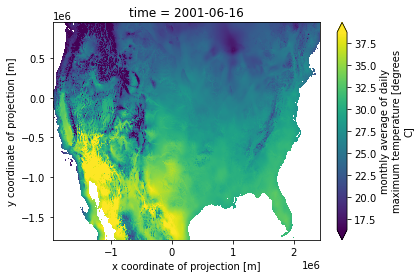

In [18]:
ds_tmax_concatJuneMonAvg.tmax[10].plot(robust=True) # Plot tmax[10] Average Maximum Temperature for June 2001

In [19]:
# Looking at the numpy array of Monthly Average Maximum Temperature data - for one year
ds_tmax_concatJuneMonAvg.tmax[10].data

array([[      nan,       nan,       nan, ..., 23.922333, 23.839666,
        23.888   ],
       [      nan,       nan,       nan, ..., 23.857666, 23.833   ,
        23.876667],
       [      nan,       nan,       nan, ..., 23.829   , 23.867332,
        23.841667],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

- ##### We can look at the values of the coordinates

In [20]:
#ds_tmax_concatJuneMonAvg.tmax.x
#ds_tmax_concatJuneMonAvg.tmax.y
ds_tmax_concatJuneMonAvg.tmax.time

<xarray.DataArray 'time' (time: 30)>
array(['1991-06-16T00:00:00.000000000', '1992-06-16T00:00:00.000000000',
       '1993-06-16T00:00:00.000000000', '1994-06-16T00:00:00.000000000',
       '1995-06-16T00:00:00.000000000', '1996-06-16T00:00:00.000000000',
       '1997-06-16T00:00:00.000000000', '1998-06-16T00:00:00.000000000',
       '1999-06-16T00:00:00.000000000', '2000-06-16T00:00:00.000000000',
       '2001-06-16T00:00:00.000000000', '2002-06-16T00:00:00.000000000',
       '2003-06-16T00:00:00.000000000', '2004-06-16T00:00:00.000000000',
       '2005-06-16T00:00:00.000000000', '2006-06-16T00:00:00.000000000',
       '2007-06-16T00:00:00.000000000', '2008-06-16T00:00:00.000000000',
       '2009-06-16T00:00:00.000000000', '2010-06-16T00:00:00.000000000',
       '2011-06-16T00:00:00.000000000', '2012-06-16T00:00:00.000000000',
       '2013-06-16T00:00:00.000000000', '2014-06-16T00:00:00.000000000',
       '2015-06-16T00:00:00.000000000', '2016-06-16T00:00:00.000000000',
       '2017-06-16T00:00:00.000000000', '2018-06-16T00:00:00.000000000',
       '2019-06-16T00:00:00.000000000', '2020-06-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1991-06-16 1992-06-16 ... 2020-06-16
Attributes:
    standard_name:  time
    long_name:      24-hour day based on local time
    _ChunkSizes:    1

### Let's look at Xarray's Positional Indexing
* **`isel`** is *positional* Indexing using dimension names
* **`sel`** allows selection by label (or logical location) instead of integer locations 

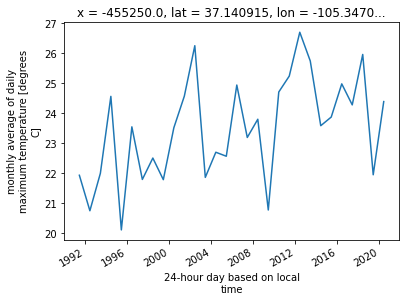

In [21]:
ds_tmax_concatJuneMonAvg.tmax.isel(y=1500, x=1500).plot() #isel - the position index along the array

- ##### But we can't sel on an intuitive label, like `lon,lat`, because Daymet is project and `x,y` are the dimensions.
- This next block will throw an error.

In [22]:
ds_tmax_concatJuneMonAvg.tmax.sel(lon=122.68, lat=45.52, method="nearest")#.plot() #isel - the position index along the array

ValueError: dimensions or multi-index levels ['lon', 'lat'] do not exist

### How do we select a latitude / longitude location ?
#### Portland, Oregon - Geographic Location:  45.52, -122.681944
* Determine the Daymet `x,y` projected values of the lon/lat for Portland, OR

In [23]:
from shapely.geometry import Point
import pyproj
# we defined daymet_proj above, but here it is again
# daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"

portland_lat = [45.52]
portland_lon = [-122.681944]

df = [Point(xy) for xy in zip(portland_lon,portland_lat)]
geo_portland = gpd.GeoDataFrame(df, geometry=df)
geo_portland.crs = 'epsg:4326'

print(geo_portland)

lcc_portland = geo_portland.to_crs(daymet_proj)
lcc_portland.bounds.round(2)

                           0                     geometry
0  POINT (-122.681944 45.52)  POINT (-122.68194 45.52000)


,minx,miny,maxx,maxy
0,-1670074.83,548467.0,-1670074.83,548467.0


Monthly Average June Maximum Temperature for Portland, Oregon: 1991 - 2020


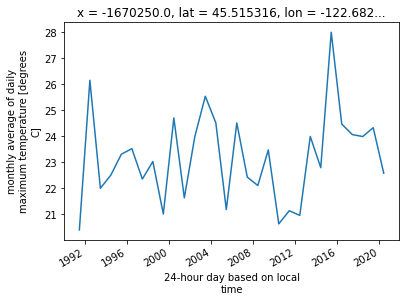

In [24]:
ds_tmax_concatJuneMonAvg.tmax.sel(y=548466.996, x=-1670074.829, method="nearest").plot()  #(minx -1670074.829, miny 548466.996)
print("Monthly Average June Maximum Temperature for Portland, Oregon: 1991 - 2020")

## Step 1.5. Derive 30-yr June Normal (1991 - 2021)

##### **Let's get back to calculating a climatology from our CONUS subset of Annual Average Maximum Temperature .**

 `tmax_concatJuneMonAvg_conussubset.nc`

The [National Centers for Environmental Information (NCEI)](https://www.ncei.noaa.gov/products/land-based-station/us-climate-normals) defines a **`Climate Normal`** as:

A "normal" is the 30-year average of a particular variable’s measurements, calculated for a uniform time period. Climate normals are derived from weather and climate observations captured by weather stations. The NCEI has produced the 1991–2020 U.S. Climate Normals as the latest in a series of decadal normals first produced in the 1950s.

##### Xarray Computation
- Xarray allows a simple **`aggregation or data reduction`** (reducing the data array along some dimension) on data sets and data arrays. 

- Xarray supports many aggregation computation methods including, but not limited to: max, min, mean, sum, std, var

- Xarray allows us to apply operations over dimension `by name`

- We can use Xarray's computation to easily calculate a 30-year June average Maximum Temperature `Normal`


In [25]:
# Here, we are deriving and plotting the 30yr Normal for the month of June
tmax_30yrJuneNormal_1991_2020 = ds_tmax_concatJuneMonAvg.mean('time')

Text(0.5, 0.98, '30-yr Normal Maximum Temperature: June')

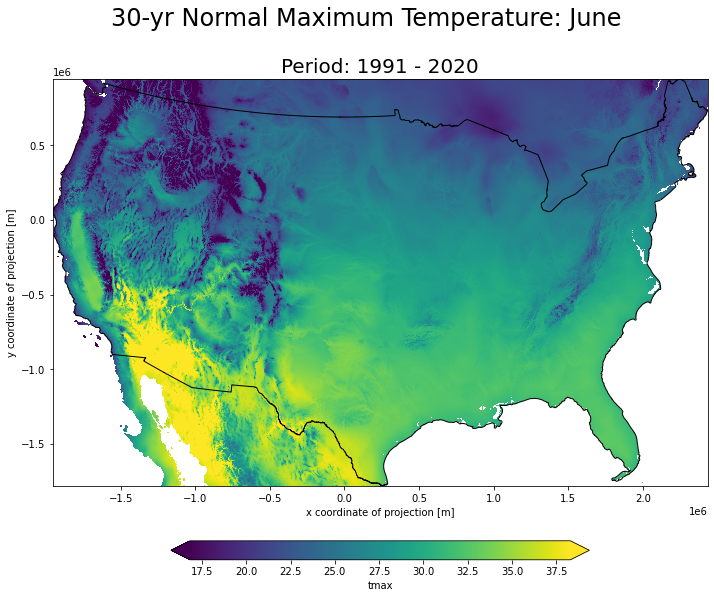

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,10))
tmax_30yrJuneNormal_1991_2020.tmax.plot(ax=ax, robust=True, cbar_kwargs={"orientation": "horizontal","shrink": 0.5, "pad": 0.1})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')
ax.set_title('Period: 1991 - 2020', fontsize=20)
fig.suptitle("30-yr Normal Maximum Temperature: June", fontsize=24)

In [27]:
tmax_30yrJuneNormal_1991_2020.to_netcdf(var + '_30yrJuneNormal_conus.nc')

----

## Step 2. June 2021 Anomaly:  Access June 2021 Daily Lower Latency Files

We'll use the **`Daymet V4 Daily Data Lower Latency`** files in this exercise.

[Daymet V4 Daily Data - Monthly Latency](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1904/catalog.html) 
`https://doi.org/10.3334/ORNLDAAC/1904`

ORNL DAAC THREDDS Data Server and OPeNDAP URL `https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/daymet_v4ll_daily_na_tmax_202106.nc`

The file name is:  **`daymet_v4ll_daily_na_tmax_202106.nc`**

## Step 2.1.
* ##### We'll directly access the ORNL DAAC OPeNDAP file

In [28]:
# OPeNDAP URL : https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/daymet_v4ll_daily_na_tmax_202106.nc
ll_granule_name = 'daymet_v4ll_daily_na_tmax_202106.nc'
ll_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/'
ll_granule_dap = ll_thredds_url + ll_granule_name
print(ll_granule_dap)

ll_thredds_ds = open_url(ll_granule_dap)

ds_tmax_202106 = xr.open_dataset(xr.backends.PydapDataStore(ll_thredds_ds), decode_coords="all")
print(ds_tmax_202106['tmax'])


https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/daymet_v4ll_daily_na_tmax_202106.nc
<xarray.DataArray 'tmax' (time: 30, y: 8075, x: 7814)>
[1892941500 values with dtype=float32]
Coordinates:
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2021-06-01T12:00:00 ... 20...
    lambert_conformal_conic  int16 ...
Attributes:
    long_name:     daily maximum temperature
    units:         degrees C
    cell_methods:  area: mean time: maximum
    _ChunkSizes:   [10, 300, 300]


* ##### Subset the Daymet Daily Lower Latency June 2021 file to CONUS
* ##### Derive the 2021 June Average Maximum Temperature

In [30]:
# TAKES A LITTLE TIME TO RUN, CONSIDER NOT DURING WEBINAR
## Subset the June 2021 file to CONUS
## Derive the 2021 June Average Maximum Temperature
import time
before = time.time()
tmax_202106_conus=ds_tmax_202106['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), 
                                             y=slice(lccbounds.maxy[0],lccbounds.miny[0]))

tmaxavg_202106_conus = tmax_202106_conus.mean('time')

print("Processing Time: ", time.time() - before, 'seconds')
tmaxavg_202106_conus.to_netcdf(var + '_avg_202106_conus.nc')  
# Processing Time:  156.8440022468567 seconds

Processing Time:  54.295344829559326 seconds


## Step 2.2.
### Derive the June 2021 Anomaly
* Mathematical operations (e.g., x - y) vectorize across multiple dimensions (array broadcasting) based on dimension names, not shape.

* Open the `30 Year June Normal` and `2021 June Average Maximum Temperature` files using Xarray `open_dataset`
* **Anomaly = 2021AvgJune - 30yrNormalJune**


In [31]:
# open files
ds_tmax_30yrJuneNormal_91_20 = xr.open_dataset('tmax_30yrJuneNormal_conus.nc')
ds_tmax_avg_202106 = xr.open_dataset('tmax_avg_202106_conus.nc')

# Derive the June Anomaly
tmax_June2021_Anomaly_91_20 = (ds_tmax_avg_202106['tmax'] - ds_tmax_30yrJuneNormal_91_20['tmax'] )
tmax_June2021_Anomaly_91_20.to_netcdf('tmax_anomaly_June2021.nc')  

## Step 2.3.
* ##### Clip the June Anomaly to our area of interest: CONUS

In [32]:
# Clip the Anomaly to our area of interest: CONUS
from rasterio.features import Affine
res = 1000 # daymet spatial resolution is 1km x 1km
#transform = Affine.translation(min(tmax.x).values - res / 2, min(tmax.y).values - res / 2) * Affine.scale(res, res)
transform = Affine.translation(min(tmax_June2021_Anomaly_91_20.x).values - res / 2, 
                               min(tmax_June2021_Anomaly_91_20.y).values - res / 2) * Affine.scale(res, res)
transform

Affine(1000.0, 0.0, -1955750.0,
       0.0, 1000.0, -1785500.0)

In [33]:
from rasterio.features import geometry_mask
#conus_mask = geometry_mask(conus_poly_lcc.geometry, out_shape=(len(tmax.y), len(tmax.x)), transform=transform, invert=True)
conus_mask = geometry_mask(conus_poly_lcc.geometry, 
                           out_shape=(len(tmax_June2021_Anomaly_91_20.y), len(tmax_June2021_Anomaly_91_20.x)),
                           transform=transform, 
                           invert=True)
polymask = xr.DataArray(conus_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1)) 
tmaxJune21anomaly_masked = tmax_June2021_Anomaly_91_20.where(polymask == True)
tmaxJune21anomaly_masked.to_netcdf(var + 'anomalyJune2021_conus.nc')

* ##### Plot the June 2021 Maximum Temperature Anomaly

Text(0.5, 0.98, 'Maximum Temperature Anomaly: June 2021')

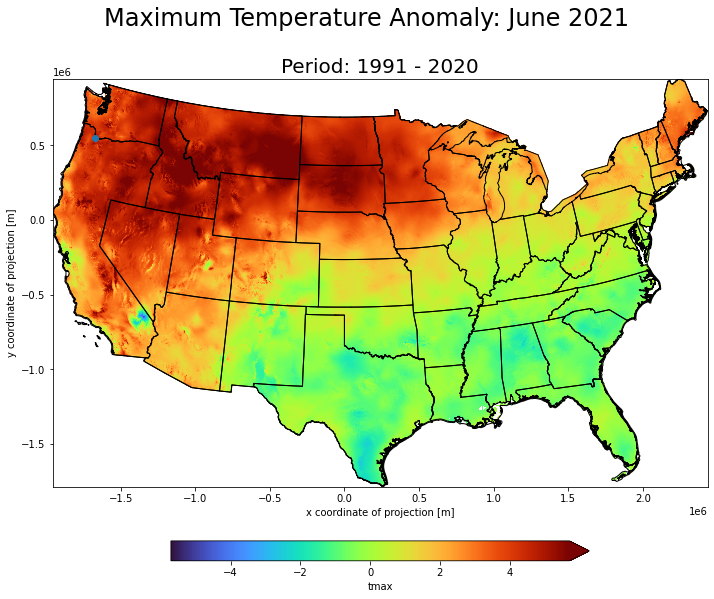

In [34]:
states_lcc = gpd.read_file('bnds/CONUS.shp')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,10))
tmaxJune21anomaly_masked.plot(ax=ax, robust=True, cmap="turbo", cbar_kwargs={"orientation": "horizontal","shrink": 0.5, "pad": 0.1})
# tmaxJune21anomaly_masked.plot(ax=ax, robust=True, cmap="turbo", cbar_kwargs={"orientation": "horizontal","shrink": 0.5, "pad": 0.1})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')
states_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')
lcc_portland.plot(ax = ax)#, color = 'none', edgecolor = 'black')
ax.set_title('Period: 1991 - 2020', fontsize=20)
fig.suptitle("Maximum Temperature Anomaly: June 2021", fontsize=24)

* ##### The June 2021 Maximum Temperature Anomaly for Portland, OR (degrees C)

In [35]:
# The June 2021 Maximum Temperature Anomaly for Portland, OR (degrees C)
tmaxJune21anomaly_masked.sel(y=548466.996, x=-1670074.829, method="nearest")

<xarray.DataArray 'tmax' ()>
array(4.532686, dtype=float32)
Coordinates:
    y                        float64 5.48e+05
    x                        float64 -1.67e+06
    lambert_conformal_conic  int16 ...

# END FOR WEBINAR

----

----

# Exercise 2:  Daymet V4 Annual Normal

![title](images/Tmax_Normal91-20.png)

In this exercise, we're interested in deriving a 30-year Climate Normal for CONUS from the **`Daymet V4 Annual Climatologies`**.  Annual climatologies are available from the ORNL DAAC. 

[Daymet V4 Annual Climatologies](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1852) `DOI: https://doi.org/10.3334/ORNLDAAC/1852`

## Step 1. Searching NASA's Collections for Daymet V4 Annual Climatology "Concept ID" 

### Step 1.1
#### Using Python's **`requests`** library, we will build and provide an HTTP request to search **`NASA's Earthdata Collections`** to acquire the Annual Climates collection **concept_id**

* **`requests`** is a simple HTTP libray for Python.  It allows you to easily send HTTP requests.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/collections
</div>

To build the URL Request we'll use:
- the cmr URL
- Daymet V4 Annual Climates DOI

In [36]:
import requests
daymet_doi = '10.3334/ORNLDAAC/1852' # ANNUAL CLIMATES define the DOI as the variable `daymet_doi`
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doisearch = cmrurl + 'collections.json?doi=' + daymet_doi # 
print('Earthdata Collections URL --> ' , doisearch)
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0]
#print(collection)
concept_id = collection['id']
print('NASA Earthdata Concept_ID --> ' , concept_id)

Earthdata Collections URL -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1852
NASA Earthdata Concept_ID -->  C2024906228-ORNL_CLOUD


#### Let's examine all of the search parameters we've established.

In [37]:
print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variable :', var)
print('bounding box    :')
print(xy_list)
print('concept ID      :', concept_id)
print('cmr url         :', cmrurl)

Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 1991-01-01T00:00:00Z,2020-12-31T00:00:00Z
Daymet variable : tmax
bounding box    :
[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]
concept ID      : C2024906228-ORNL_CLOUD
cmr url         : https://cmr.earthdata.nasa.gov/search/


### Step 1.2. 
#### Searching NASA's Earthdata Holdings for Daymet Granules (Files)

Now that we have all our parameters defined, let's do a granule-level search of NASA's Earthdata Holdings for all the data that are within those search criteria.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>

In [38]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_list))
print(granulesearch) 

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2024906228-ORNL_CLOUD&page_size=1000&temporal=1991-01-01T00:00:00Z,2020-12-31T00:00:00Z&bounding_box[]=-124.84897400000001,24.39630800000002,-66.88507499999997,49.38435799999999


##### By clicking on the CMR URL `granulesearch` above, we see NASA's common metadata repository (CMR) for the Daymet V4 Annual Climatologies.  

##### Now we search within this to find the individual files (or granules) that we are interested in based on the search parameters we defined in **`granulesearch`**. 

In [39]:
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']  
granule_names = []  # Here, we're creating a Python list of granule_names found in the CMR URL based on our search criteria

for g in granules:
    granule_name = g['title']
    if var in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1991.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1991.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1992.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1992.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1993.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1993.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1994.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1994.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1995.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1995.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1996.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1996.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1997.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1997.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1998.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1998.nc


**We see that we have the years of interest (1991 - 2020) and the variable of interest (tmax).  We'll further reduce this to only the netCDF files (available thru OPeNDAP) below.**  

**Just the North American (na) files are listed because they are within the spatial domain of CONUS, which we established in our search.**

## Step 2.  Programmatically access, subset, and download: Daymet V4 Annual Climate files

Daymet V4 Annaul Climatology data is available through ORNL DAAC's THREDDS Data Server. We will use this to subset and download  based on
- **`granual_names`** array we saved above 
- our polygonal region of interest (LCC bounding box)
- our time range of interest
- Daymet variable

[Daymet V4 Annual Climate Summaries in the ORNL DAAC THREDDS Data Server](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1852/catalog.html)

###  We'll use Pythons **`pydap`** library

* **`pydap`** can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally.  Data can be downloaded on-the-fly as needed.

###  We'll use Python's **`Xarray`** Library to 
* open the data files for which we are searching
* subset the North American file based on the Lambert Conformal Conic **`lccbounds`** bounding box we defined earlier
* concatenate the time range into one file
* save the concatened file to a netCDF file

Xarray
* **xarray `open_dataset`** 
* **xarray `sel`**
* **xarray `slice`**
* **xarray `concat`**
* **xarray `to_netcdf`**

In [40]:
###### DO NOT RUN IN WEBINAR #####
# Programmatically select for netCDF files
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr
import time

before = time.time()
cnt = 0
for g_name in granule_names: 
    if '.nc' in g_name:  # selecting for ONLY the netCDF files
        print(' ***GRANULE_NAME*** ---->', g_name)
        thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1852/'
        granule_dap = thredds_url + g_name.replace('Daymet_V4_Annual_Climatology.','')
        
        thredds_ds = open_url(granule_dap)   
        ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")
        
        temp=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    
        if cnt==0:
            tmax = temp
        else:
            tmax = xr.concat([tmax, temp], dim="time")
    
        cnt += 1
    

# save concatenated file (eg. 30 time steps; 1991- 2020) to netcdf
#tmax.to_netcdf(var + '_concatAnnAvg_conussubset.nc') # this file is opened below
tmax.to_netcdf(var + '_concatAnnAvg_conussubset_demo.nc') # this file is a "demo" for the webinar
print("Processing Time: ", time.time() - before, 'seconds')
#Processing Time:  431.438472032547 seconds seconds (about 7 min.)

 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1991.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1992.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1993.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1994.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1995.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1996.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1997.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1998.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1999.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_2000.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_2001.nc
 ***GRANULE_NAME*** ----> Daymet

The step above takes about 7 minues to run from within the ORNL DAAC.  

That's remotely **accessing** the data, **subsetting** to a region and time of interest, and **concatenating** 30 years of data into one file.  That's pretty good compared to downloading each file separately and doing the subsetting in a separate system.

**netCDF file created:  `tmax_concatAnnAvg_conussubset.nc`**


## Step 3. 30-years (1991 - 2020) of Annual Average Maximum Temperture 


### Xarray
We'll use the Python Package **`Xarray`** to explore and analyze the 30yr Annual Mean Maximum Temperature dataset we've downloaded.

- [**`Xarray`**](http://xarray.pydata.org/en/stable/) is "a Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!"
<br>
- [Xarray](http://xarray.pydata.org/en/stable/) introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.

- Xarray is particularly tailored to working with netCDF files, which were the source of xarray’s data model.  Xarray allows label-based indexing from the array of data.  And so, for example, we can select time series data by date/time instead of index position.

### Step 3.1. Let's explore `Xarray` : 30-year Annual Avg Maximum Temperature File

#### Use Xarray's **`open_dataset`**  to open the file we subset and downloaded above `tmax_concatAnnAvg_conussubset.nc`.

In [41]:
import xarray as xr
ds_tmax_concatAnnAvg = xr.open_dataset('tmax_concatAnnAvg_conussubset_demo.nc') 

- ##### Xarray `Dataset.info` : Concise summary of a Dataset variables and attributes.

In [42]:
#netCDF file representation
ds_tmax_concatAnnAvg.info()

xarray.Dataset {
dimensions:
	time = 30 ;
	x = 4390 ;
	y = 2732 ;

variables:
	float32 x(x) ;
		x:units = m ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
		x:_ChunkSizes = 7814 ;
	float32 lat(y, x) ;
		lat:units = degrees_north ;
		lat:long_name = latitude coordinate ;
		lat:standard_name = latitude ;
		lat:_ChunkSizes = [1010  977] ;
	float32 lon(y, x) ;
		lon:units = degrees_east ;
		lon:long_name = longitude coordinate ;
		lon:standard_name = longitude ;
		lon:_ChunkSizes = [1010  977] ;
	float32 y(y) ;
		y:units = m ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
		y:_ChunkSizes = 8075 ;
	float32 tmax(time, y, x) ;
		tmax:units = degrees C ;
		tmax:cell_methods = area: mean time: maximum within days time: mean over days ;
		tmax:long_name = annual average of daily maximum temperature ;
		tmax:_ChunkSizes = [   1 1000 1000] ;
		tmax:grid_mapping = lambert_conformal_conic ;
	datetime64[ns] tim

- ##### Xarray's (html) representation

In [43]:
ds_tmax_concatAnnAvg

<xarray.Dataset>
Dimensions:                  (time: 30, x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
  * time                     (time) datetime64[ns] 1991-07-02T12:00:00 ... 20...
Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 ...

- ##### Xarray `Dataset.data_vars` : Dictionary of DataArray objects corresponding to data variables.

In [44]:
ds_tmax_concatAnnAvg.data_vars

Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 -32767

- ##### Xarray `Dataset.dims` : Dictionary of DataArray objects corresponding to data variables.

In [45]:
ds_tmax_concatAnnAvg.tmax.dims
# Here we can see the arrangment of the dimensions.  Time is the first dimension.

('time', 'y', 'x')

- ##### Visualize **`tmax`** of the Dataset
##### We can see that Xarray is able to read the attributes of the netCDF and apply them to the plot 

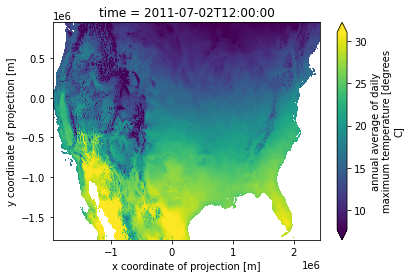

In [46]:
ds_tmax_concatAnnAvg.tmax[20].plot(robust=True) # Plot tmax[0] the first year (1991) of the 30-year concatenated fil

In [47]:
# Looking at the numpy array of Annual Average Maximum Temperature data - for one year
ds_tmax_concatAnnAvg.tmax[1].data

array([[     nan,      nan,      nan, ..., 9.866959, 9.804055, 9.857589],
       [     nan,      nan,      nan, ..., 9.796384, 9.787452, 9.845096],
       [     nan,      nan,      nan, ..., 9.758657, 9.811069, 9.802301],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)

In [48]:
ds_tmax_concatAnnAvg.tmax[0]

<xarray.DataArray 'tmax' (y: 2732, x: 4390)>
[11993480 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1.955e+06 -1.954e+06 ... 2.433e+06 2.434e+06
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * y        (y) float32 9.46e+05 9.45e+05 9.44e+05 ... -1.784e+06 -1.785e+06
    time     datetime64[ns] 1991-07-02T12:00:00
Attributes:
    units:         degrees C
    cell_methods:  area: mean time: maximum within days time: mean over days
    long_name:     annual average of daily maximum temperature
    _ChunkSizes:   [   1 1000 1000]
    grid_mapping:  lambert_conformal_conic

- ##### We can look at the values of the coordinates

In [49]:
# ds_tmax_concatAnnAvg.tmax.x
# ds_tmax_concatAnnAvg.tmax.y
ds_tmax_concatAnnAvg.tmax.time

<xarray.DataArray 'time' (time: 30)>
array(['1991-07-02T12:00:00.000000000', '1992-07-01T12:00:00.000000000',
       '1993-07-02T12:00:00.000000000', '1994-07-02T12:00:00.000000000',
       '1995-07-02T12:00:00.000000000', '1996-07-01T12:00:00.000000000',
       '1997-07-02T12:00:00.000000000', '1998-07-02T12:00:00.000000000',
       '1999-07-02T12:00:00.000000000', '2000-07-01T12:00:00.000000000',
       '2001-07-02T12:00:00.000000000', '2002-07-02T12:00:00.000000000',
       '2003-07-02T12:00:00.000000000', '2004-07-01T12:00:00.000000000',
       '2005-07-02T12:00:00.000000000', '2006-07-02T12:00:00.000000000',
       '2007-07-02T12:00:00.000000000', '2008-07-01T12:00:00.000000000',
       '2009-07-02T12:00:00.000000000', '2010-07-02T12:00:00.000000000',
       '2011-07-02T12:00:00.000000000', '2012-07-01T12:00:00.000000000',
       '2013-07-02T12:00:00.000000000', '2014-07-02T12:00:00.000000000',
       '2015-07-02T12:00:00.000000000', '2016-07-01T12:00:00.000000000',
       '2017-07-02T12:00:00.000000000', '2018-07-02T12:00:00.000000000',
       '2019-07-02T12:00:00.000000000', '2020-07-01T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1991-07-02T12:00:00 ... 2020-07-01T12:00:00
Attributes:
    standard_name:  time
    long_name:      24-hour day based on local time
    _ChunkSizes:    1

### Let's look at Positional Indexing
* **`isel`** is *positional* Indexing using dimension names
* **`sel`** allows selection by label (or logical location) instead of integer locations 

### How do we select a latitude / longitude location ?
#### Portland, Oregon - Geographic Location:  45.52, -122.681944
* Determine the Daymet `x,y` projected values of the lon/lat for Portland, OR

In [50]:
from shapely.geometry import Point
import pyproj
# we defined daymet_proj above, but here it is again
# daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"

portland_lat = [45.52]
portland_lon = [-122.681944]

df = [Point(xy) for xy in zip(portland_lon,portland_lat)]
geo_portland = gpd.GeoDataFrame(df, geometry=df)
geo_portland.crs = 'epsg:4326'

print(geo_portland)

lcc_portland = geo_portland.to_crs(daymet_proj)
lcc_portland.bounds.round(2)

                           0                     geometry
0  POINT (-122.681944 45.52)  POINT (-122.68194 45.52000)


,minx,miny,maxx,maxy
0,-1670074.83,548467.0,-1670074.83,548467.0


Annual Average Maximum Temperature for Portland, Oregon: 1991 - 2020


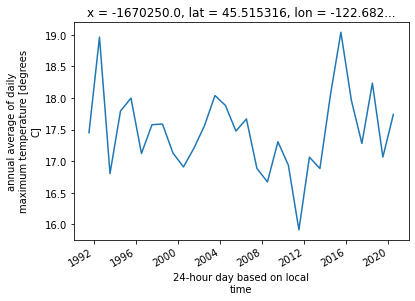

In [51]:
ds_tmax_concatAnnAvg.tmax.sel(y=548466.996, x=-1670074.829, method="nearest").plot()  #(minx -1670074.829, miny 548466.996)
print("Annual Average Maximum Temperature for Portland, Oregon: 1991 - 2020")

### Step 3.2. 30-year Climate Normal : Maximum Temperature 

##### **Let's get back to calculating a climatology from our CONUS subset of Annual Average Maximum Temperature .**

 `tmax_concatAnnAvg_conussubset.nc`

The [National Centers for Environmental Information (NCEI)](https://www.ncei.noaa.gov/products/land-based-station/us-climate-normals) defines a **`Climate Normal`** as:

A "normal" is the 30-year average of a particular variable’s measurements, calculated for a uniform time period. Climate normals are derived from weather and climate observations captured by weather stations. The NCEI has produced the 1991–2020 U.S. Climate Normals as the latest in a series of decadal normals first produced in the 1950s.

##### Xarray Computation
- Xarray allows a simple **`aggregation or data reduction`** (reducing the data array along some dimension) on data sets and data arrays. 

- Xarray supports many aggregation computation methods including, but not limited to: max, min, mean, sum, std, var

- Xarray allows us to apply operations over dimension by name

- We can use Xarray's computation to easily calculate a 30-year average Maximum Temperature `Normal`



In [52]:
tmax_30yrNormal_1991_2020 = ds_tmax_concatAnnAvg.mean('time')
tmax_30yrNormal_1991_2020

<xarray.Dataset>
Dimensions:                  (x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
Data variables:
    tmax                     (y, x) float32 nan nan nan nan ... nan nan nan nan
    lambert_conformal_conic  float64 -3.277e+04

##### Let's plot the result of the 30-year average Maximum Temperature Normal

Text(0.5, 0.98, '30-yr Normal Maximum Temperature: Annual')

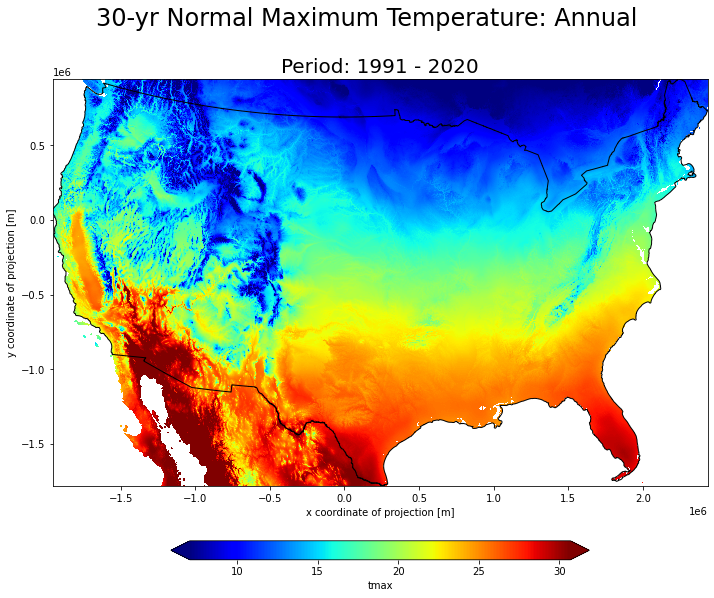

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,10))
tmax_30yrNormal_1991_2020.tmax.plot(ax=ax, robust=True, cmap="jet", cbar_kwargs={"orientation": "horizontal","shrink": 0.5, "pad": 0.1})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')
ax.set_title('Period: 1991 - 2020', fontsize=20)
fig.suptitle("30-yr Normal Maximum Temperature: Annual", fontsize=24)

In [54]:
#save using to_netcdf method
tmax_30yrNormal_1991_2020.to_netcdf('DaymetV4_tmax_Normal_1991_2020.nc')

---
---

END

## Exercise 3.  Annual Seasonal Means

**In this exercise, we'll derive Annual Seasonal Means from Daymet Monthly files spanning 2010 and 2011**

![title](images/season_climates.png)

In [55]:
# SET UP SEARCH PARAMETERS
import requests
m_daymet_doi = '10.3334/ORNLDAAC/1855' # Monthly CLIMATES DOI
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
m_doisearch = cmrurl + 'collections.json?doi=' + m_daymet_doi # 
print('Earthdata Metadata for DaymetV4 Monthly Climatologies --> ' , m_doisearch)

m_response = requests.get(m_doisearch)
m_collection = m_response.json()['feed']['entry'][0]
#print(collection)
m_concept_id = m_collection['id']
print('NASA Earthdata Cloud-based Concept_ID Monthly Climates --> ' , m_concept_id)

import datetime as dt 
# We'll get 2010 - 2011, but all months for this query
start_date = dt.datetime(2010, 12, 1) # specify your own start date
end_date = dt.datetime(2011, 12, 31)  # specify your end start date

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

var = 'tmax'

# GRANULE SEARCH
m_granulesearch = cmrurl + 'granules.json?collection_concept_id=' + m_concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_list))
print(m_granulesearch)

response = requests.get(m_granulesearch)
m_granules = response.json()['feed']['entry']  
m_granule_names = []

for g in m_granules:
    m_granule_name = g['title']
    if var in m_granule_name:
        m_granule_names.append(m_granule_name)
        print(m_granule_name)
        

## EXTRACT DATA and DOWNLOAD
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr
import time

before = time.time()
cnt = 0
for m_g_name in sorted(m_granule_names): 

    if '.nc' in m_g_name:
        print(' ***GRANULE_NAME*** ---->', m_g_name)
        m_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/'
        m_granule_dap = m_thredds_url + m_g_name.replace('Daymet_V4_Monthly_Climatology.','')
        #print(m_granule_dap)
        
        m_thredds_ds = open_url(m_granule_dap) #, session=session)  
        m_ds = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")
        #print(m_ds)
        
        yr = m_ds.start_year # start_year is read from the global attributes of the file granule
        m12_temp=m_ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]),
                                y=slice(lccbounds.maxy[0],lccbounds.miny[0]),
                                time=slice(dt.datetime(2010, 12, 16), dt.datetime(2012, 1, 16)))
        if cnt==0:
            m12_tmax = m12_temp
        else:
            m12_tmax = xr.concat([m12_tmax, m12_temp], dim="time")
    
        cnt += 1
    

# save concatenated file (eg. 30 June time steps; 1991- 2020) to netcdf
m12_tmax.to_netcdf(var + '_concatSea2MonAvg_conussubset.nc') # this file is opened below
# m12_tmax.to_netcdf(var + '_concat12MonAvg_conussubset_demo.nc') # this file is a "demo" for the webinar
#print("Processing Time: ", time.time() - before, 'seconds')

Earthdata Metadata for DaymetV4 Monthly Climatologies -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1855
NASA Earthdata Cloud-based Concept_ID Monthly Climates -->  C2024906320-ORNL_CLOUD
https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2024906320-ORNL_CLOUD&page_size=1000&temporal=2010-12-01T00:00:00Z,2011-12-31T00:00:00Z&bounding_box[]=-124.84897400000001,24.39630800000002,-66.88507499999997,49.38435799999999
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_2010.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_2010.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_2011.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_2011.tif
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_2010.nc
 ***GRANULE_NAME*** ----> Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_2011.nc


In [56]:
ds = xr.open_dataset('tmax_concatSea2MonAvg_conussubset.nc')
ds

<xarray.Dataset>
Dimensions:                  (time: 13, x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
  * time                     (time) datetime64[ns] 2010-12-16T12:00:00 ... 20...
Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 ...

In [57]:
ds.groupby("time.season")

DatasetGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [58]:
seasonal_mean = ds.groupby("time.season").mean()

In [59]:
seasonal_mean

<xarray.Dataset>
Dimensions:                  (season: 4, x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 48.29 48.29 48.29 ... 22.75 22.75
    lon                      (y, x) float32 -128.1 -128.0 ... -76.28 -76.27
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
  * season                   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    tmax                     (season, y, x) float32 nan nan nan ... nan nan nan
    lambert_conformal_conic  (season) float64 -3.277e+04 ... -3.277e+04

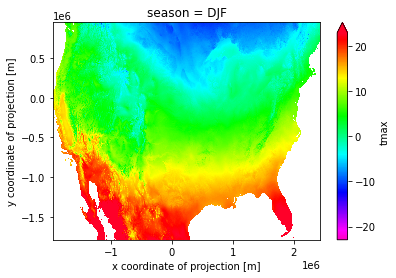

In [60]:
seasonal_mean.tmax[0].plot(robust=True, cmap="gist_rainbow_r")

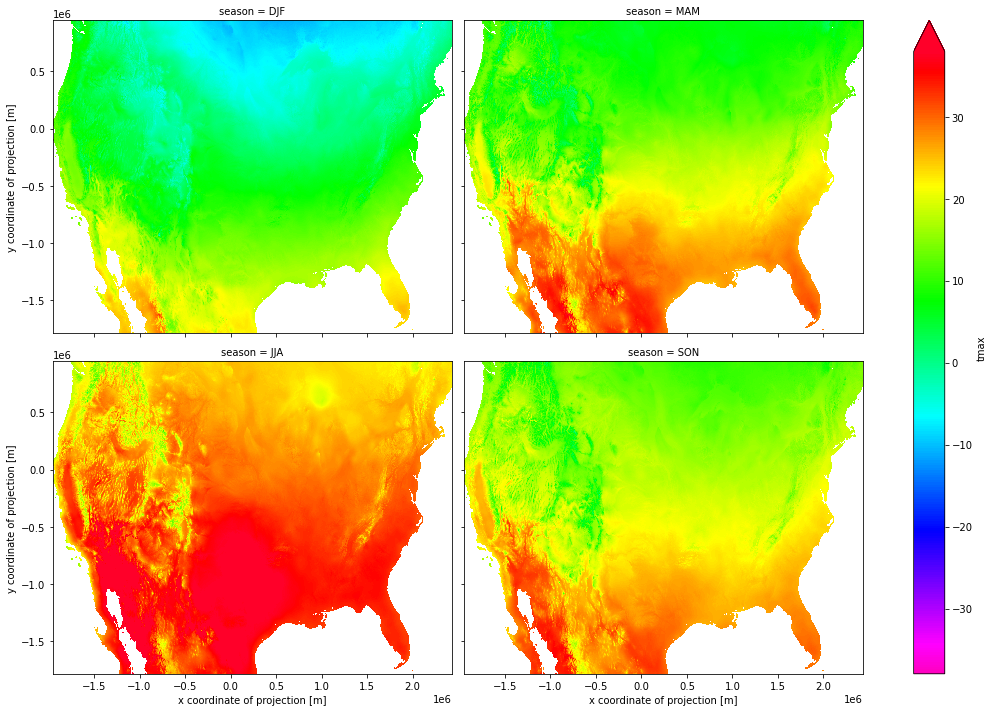

In [61]:
seasonal_mean = seasonal_mean.reindex(season=["DJF", "MAM", "JJA", "SON"])
seasonal_mean.tmax.plot(col="season", col_wrap=2, figsize=(15,10), robust=True, cmap="gist_rainbow_r")
#seasonal_mean.tmax.plot(col="season", col_wrap=2, figsize=(15,10), cmap="seismic")